<a href="https://colab.research.google.com/github/ethanchel/DI172/blob/main/multi_uav_mappo_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Agent PPO (MAPPO) for UAV Waypoint Navigation - V2

This notebook demonstrates **Multi-Agent Proximal Policy Optimization (MAPPO)** applied to a cooperative UAV navigation task:

> **Multiple UAVs must coordinate to visit shared waypoints as frequently as possible while avoiding collisions.**

---
## Problem Setup
- **Agents**: 3 UAVs operating in a 2D grid
- **Objective**: Visit all waypoints (shared pool), then repeat — maximize "laps" completed
- **Challenge**: Coordinate to avoid collisions and efficiently cover waypoints

## Algorithm: MAPPO (Centralized Training, Decentralized Execution)
- **Actors**: Each UAV has its own policy network (local observations only)
- **Critic**: Centralized value function (sees global state during training)
- **Update**: PPO with clipped surrogate objective for stability

---

## 1. Imports and Setup

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Multi-UAV Waypoint Environment (Improved)

### Key Changes from V1:
- **Smaller grid** (20x20) — easier to learn
- **Stronger rewards** for waypoints
- **Distance-based reward shaping** — guides agents toward waypoints
- **Larger capture radius** for waypoints

In [ ]:
class MultiUAVWaypointEnv:
    """
    Multi-agent environment for UAV waypoint navigation.
    Cooperative task: all UAVs share the same reward.
    """

    def __init__(self, n_agents=3, n_waypoints=4, grid_size=20, max_steps=100):
        self.n_agents = n_agents
        self.n_waypoints = n_waypoints
        self.grid_size = grid_size
        self.max_steps = max_steps

        # Action mapping: 0=stay, 1=up, 2=down, 3=left, 4=right
        self.action_map = {
            0: (0, 0),   # Stay
            1: (0, 1),   # Up (North)
            2: (0, -1),  # Down (South)
            3: (-1, 0),  # Left (West)
            4: (1, 0)    # Right (East)
        }
        self.n_actions = len(self.action_map)

        # Observation dimensions
        self.obs_dim = 2 + n_waypoints * 2 + n_waypoints + (n_agents - 1) * 2

        # Global state dimensions
        self.global_state_dim = n_agents * 2 + n_waypoints * 2 + n_waypoints

        self.reset()

    def reset(self):
        """Reset environment to initial state."""
        # Place UAVs at corners/edges (spread out)
        self.agent_positions = [
            [2, 2],
            [self.grid_size - 3, 2],
            [self.grid_size // 2, self.grid_size - 3]
        ][:self.n_agents]

        # Place waypoints in a pattern (easier to reach)
        center = self.grid_size // 2
        radius = self.grid_size // 3
        self.waypoint_positions = []
        for i in range(self.n_waypoints):
            angle = 2 * np.pi * i / self.n_waypoints
            wx = int(center + radius * np.cos(angle))
            wy = int(center + radius * np.sin(angle))
            self.waypoint_positions.append([wx, wy])

        # Waypoint status
        self.waypoint_visited = [False] * self.n_waypoints

        # Tracking
        self.steps = 0
        self.laps_completed = 0
        self.total_collisions = 0
        self.total_waypoints_visited = 0

        # Store previous distances for shaping reward
        self.prev_min_distances = self._compute_min_distances()

        return self._get_observations(), self._get_global_state()

    def _compute_min_distances(self):
        """Compute minimum distance from any agent to each unvisited waypoint."""
        min_dists = []
        for j, wp in enumerate(self.waypoint_positions):
            if not self.waypoint_visited[j]:
                min_dist = min(
                    abs(pos[0] - wp[0]) + abs(pos[1] - wp[1])
                    for pos in self.agent_positions
                )
                min_dists.append(min_dist)
            else:
                min_dists.append(0)
        return min_dists

    def _get_observations(self):
        """Get local observation for each agent."""
        observations = []

        for i in range(self.n_agents):
            obs = []

            # Own position (normalized)
            obs.extend([self.agent_positions[i][0] / self.grid_size,
                        self.agent_positions[i][1] / self.grid_size])

            # Relative position to each waypoint (normalized)
            for wp in self.waypoint_positions:
                rel_x = (wp[0] - self.agent_positions[i][0]) / self.grid_size
                rel_y = (wp[1] - self.agent_positions[i][1]) / self.grid_size
                obs.extend([rel_x, rel_y])

            # Waypoint visited status
            obs.extend([1.0 if v else 0.0 for v in self.waypoint_visited])

            # Relative position to other agents (normalized)
            for j in range(self.n_agents):
                if i != j:
                    rel_x = (self.agent_positions[j][0] - self.agent_positions[i][0]) / self.grid_size
                    rel_y = (self.agent_positions[j][1] - self.agent_positions[i][1]) / self.grid_size
                    obs.extend([rel_x, rel_y])

            observations.append(np.array(obs, dtype=np.float32))

        return observations

    def _get_global_state(self):
        """Get global state for centralized critic."""
        state = []

        for pos in self.agent_positions:
            state.extend([pos[0] / self.grid_size, pos[1] / self.grid_size])

        for wp in self.waypoint_positions:
            state.extend([wp[0] / self.grid_size, wp[1] / self.grid_size])

        state.extend([1.0 if v else 0.0 for v in self.waypoint_visited])

        return np.array(state, dtype=np.float32)

    def step(self, actions):
        """
        Execute one step with joint actions.
        """
        self.steps += 1
        reward = 0.0

        # Move agents
        new_positions = []
        for i, action in enumerate(actions):
            dx, dy = self.action_map[action]
            new_x = np.clip(self.agent_positions[i][0] + dx, 0, self.grid_size - 1)
            new_y = np.clip(self.agent_positions[i][1] + dy, 0, self.grid_size - 1)
            new_positions.append([int(new_x), int(new_y)])

        # Check for collisions
        position_counts = {}
        for pos in new_positions:
            pos_tuple = tuple(pos)
            position_counts[pos_tuple] = position_counts.get(pos_tuple, 0) + 1

        for count in position_counts.values():
            if count > 1:
                reward -= 10.0 * (count - 1)  # Collision penalty
                self.total_collisions += count - 1

        # Update positions
        self.agent_positions = new_positions

        # Check waypoint visits (larger capture radius = 3)
        for i, pos in enumerate(self.agent_positions):
            for j, wp in enumerate(self.waypoint_positions):
                if not self.waypoint_visited[j]:
                    dist = abs(pos[0] - wp[0]) + abs(pos[1] - wp[1])
                    if dist <= 3:  # Capture radius
                        self.waypoint_visited[j] = True
                        reward += 50.0  # Strong waypoint reward
                        self.total_waypoints_visited += 1

        # Distance-based reward shaping (encourage moving toward waypoints)
        curr_min_distances = self._compute_min_distances()
        for j in range(self.n_waypoints):
            if not self.waypoint_visited[j]:
                # Reward for getting closer
                dist_improvement = self.prev_min_distances[j] - curr_min_distances[j]
                reward += dist_improvement * 2.0  # Shaping reward
        self.prev_min_distances = curr_min_distances

        # Check if lap completed
        if all(self.waypoint_visited):
            reward += 100.0  # Big lap bonus
            self.laps_completed += 1
            self.waypoint_visited = [False] * self.n_waypoints
            self.prev_min_distances = self._compute_min_distances()

        # Small time penalty
        reward -= 0.5

        # Check termination
        done = self.steps >= self.max_steps

        info = {
            'laps_completed': self.laps_completed,
            'total_collisions': self.total_collisions,
            'total_waypoints_visited': self.total_waypoints_visited,
            'steps': self.steps
        }

        return self._get_observations(), self._get_global_state(), reward, done, info

# Test the environment
env = MultiUAVWaypointEnv(n_agents=3, n_waypoints=4, grid_size=20)
obs, global_state = env.reset()
print(f"Number of agents: {env.n_agents}")
print(f"Number of waypoints: {env.n_waypoints}")
print(f"Grid size: {env.grid_size}x{env.grid_size}")
print(f"Observation dim (per agent): {env.obs_dim}")
print(f"Global state dim: {env.global_state_dim}")
print(f"Number of actions: {env.n_actions}")
print(f"\nAgent starting positions: {env.agent_positions}")
print(f"Waypoint positions: {env.waypoint_positions}")

Number of agents: 3
Number of waypoints: 4
Grid size: 20x20
Observation dim (per agent): 18
Global state dim: 18
Number of actions: 5

Agent starting positions: [[2, 2], [17, 2], [10, 17]]
Waypoint positions: [[16, 10], [10, 16], [4, 10], [9, 4]]


## 3. Neural Networks

In [ ]:
class Actor(nn.Module):
    """Decentralized actor network."""

    def __init__(self, obs_dim, n_actions, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, n_actions),
            nn.Softmax(dim=-1)
        )

    def forward(self, obs):
        return self.net(obs)

    def get_action(self, obs, deterministic=False):
        probs = self.forward(obs)
        dist = Categorical(probs)

        if deterministic:
            action = probs.argmax(dim=-1)
        else:
            action = dist.sample()

        log_prob = dist.log_prob(action)
        return action, log_prob, probs


class Critic(nn.Module):
    """Centralized critic network."""

    def __init__(self, state_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state):
        return self.net(state).squeeze(-1)


# Test networks
actor = Actor(env.obs_dim, env.n_actions)
critic = Critic(env.global_state_dim)

test_obs = torch.tensor(obs[0]).unsqueeze(0)
test_state = torch.tensor(global_state).unsqueeze(0)

print(f"Actor output: {actor(test_obs).detach().numpy()}")
print(f"Critic output: {critic(test_state).item():.4f}")

Actor output: [[0.199588   0.20211394 0.2099685  0.21715489 0.17117476]]
Critic output: 0.0040


## 4. MAPPO Algorithm

In [ ]:
class RolloutBuffer:
    """Buffer to store trajectories."""

    def __init__(self):
        self.clear()

    def clear(self):
        self.observations = []
        self.global_states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.dones = []
        self.values = []

    def add(self, obs, global_state, actions, log_probs, reward, done, value):
        self.observations.append(obs)
        self.global_states.append(global_state)
        self.actions.append(actions)
        self.log_probs.append(log_probs)
        self.rewards.append(reward)
        self.dones.append(done)
        self.values.append(value)

    def compute_returns_and_advantages(self, last_value, gamma=0.99, gae_lambda=0.95):
        rewards = np.array(self.rewards)
        dones = np.array(self.dones)
        values = np.array(self.values + [last_value])

        advantages = np.zeros_like(rewards)
        gae = 0

        for t in reversed(range(len(rewards))):
            delta = rewards[t] + gamma * values[t + 1] * (1 - dones[t]) - values[t]
            gae = delta + gamma * gae_lambda * (1 - dones[t]) * gae
            advantages[t] = gae

        returns = advantages + values[:-1]
        return returns, advantages

    def get_batches(self, returns, advantages, n_agents):
        obs_per_agent = [[] for _ in range(n_agents)]
        actions_per_agent = [[] for _ in range(n_agents)]
        log_probs_per_agent = [[] for _ in range(n_agents)]

        for t in range(len(self.observations)):
            for i in range(n_agents):
                obs_per_agent[i].append(self.observations[t][i])
                actions_per_agent[i].append(self.actions[t][i])
                log_probs_per_agent[i].append(self.log_probs[t][i])

        obs_tensors = [torch.tensor(np.array(obs), dtype=torch.float32) for obs in obs_per_agent]
        action_tensors = [torch.tensor(actions, dtype=torch.long) for actions in actions_per_agent]
        old_log_prob_tensors = [torch.tensor(lp, dtype=torch.float32) for lp in log_probs_per_agent]

        global_states_tensor = torch.tensor(np.array(self.global_states), dtype=torch.float32)
        returns_tensor = torch.tensor(returns, dtype=torch.float32)
        advantages_tensor = torch.tensor(advantages, dtype=torch.float32)

        advantages_tensor = (advantages_tensor - advantages_tensor.mean()) / (advantages_tensor.std() + 1e-8)

        return {
            'obs': obs_tensors,
            'actions': action_tensors,
            'old_log_probs': old_log_prob_tensors,
            'global_states': global_states_tensor,
            'returns': returns_tensor,
            'advantages': advantages_tensor
        }


class MAPPOAgent:
    """Multi-Agent PPO with CTDE."""

    def __init__(self, obs_dim, global_state_dim, n_actions, n_agents,
                 lr_actor=3e-4, lr_critic=1e-3, gamma=0.99, gae_lambda=0.95,
                 clip_epsilon=0.2, entropy_coef=0.01, max_grad_norm=0.5, n_epochs=4):

        self.n_agents = n_agents
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.clip_epsilon = clip_epsilon
        self.entropy_coef = entropy_coef
        self.max_grad_norm = max_grad_norm
        self.n_epochs = n_epochs

        self.actor = Actor(obs_dim, n_actions).to(device)
        self.critic = Critic(global_state_dim).to(device)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)

        self.buffer = RolloutBuffer()

    def select_actions(self, observations, deterministic=False):
        actions = []
        log_probs = []

        for obs in observations:
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)

            with torch.no_grad():
                action, log_prob, _ = self.actor.get_action(obs_tensor, deterministic)

            actions.append(action.item())
            log_probs.append(log_prob.item())

        return actions, log_probs

    def get_value(self, global_state):
        state_tensor = torch.tensor(global_state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            value = self.critic(state_tensor)
        return value.item()

    def store_transition(self, obs, global_state, actions, log_probs, reward, done, value):
        self.buffer.add(obs, global_state, actions, log_probs, reward, done, value)

    def update(self):
        if len(self.buffer.rewards) == 0:
            return 0, 0

        last_value = 0 if self.buffer.dones[-1] else self.get_value(self.buffer.global_states[-1])

        returns, advantages = self.buffer.compute_returns_and_advantages(
            last_value, self.gamma, self.gae_lambda
        )

        batch = self.buffer.get_batches(returns, advantages, self.n_agents)

        actor_losses = []
        critic_losses = []

        for _ in range(self.n_epochs):
            total_actor_loss = 0
            total_entropy = 0

            for i in range(self.n_agents):
                obs = batch['obs'][i].to(device)
                actions = batch['actions'][i].to(device)
                old_log_probs = batch['old_log_probs'][i].to(device)
                advantages_i = batch['advantages'].to(device)

                probs = self.actor(obs)
                dist = Categorical(probs)
                new_log_probs = dist.log_prob(actions)
                entropy = dist.entropy().mean()

                ratio = torch.exp(new_log_probs - old_log_probs)
                surr1 = ratio * advantages_i
                surr2 = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * advantages_i
                actor_loss = -torch.min(surr1, surr2).mean()

                total_actor_loss += actor_loss
                total_entropy += entropy

            total_actor_loss = total_actor_loss / self.n_agents
            total_entropy = total_entropy / self.n_agents

            actor_loss_with_entropy = total_actor_loss - self.entropy_coef * total_entropy

            self.actor_optimizer.zero_grad()
            actor_loss_with_entropy.backward()
            nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
            self.actor_optimizer.step()

            # Critic update
            global_states = batch['global_states'].to(device)
            returns_tensor = batch['returns'].to(device)

            values = self.critic(global_states)
            critic_loss = nn.MSELoss()(values, returns_tensor)

            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
            self.critic_optimizer.step()

            actor_losses.append(total_actor_loss.item())
            critic_losses.append(critic_loss.item())

        self.buffer.clear()

        return np.mean(actor_losses), np.mean(critic_losses)

print("MAPPO Agent initialized successfully!")

MAPPO Agent initialized successfully!


## 5. Training Loop

In [ ]:
# Hyperparameters - TUNED FOR BETTER LEARNING
N_AGENTS = 3
N_WAYPOINTS = 4  # Fewer waypoints = easier
GRID_SIZE = 20   # Smaller grid = easier
MAX_STEPS = 100

N_EPISODES = 800
UPDATE_FREQ = 400  # Update more frequently

# Initialize
env = MultiUAVWaypointEnv(n_agents=N_AGENTS, n_waypoints=N_WAYPOINTS,
                          grid_size=GRID_SIZE, max_steps=MAX_STEPS)

agent = MAPPOAgent(
    obs_dim=env.obs_dim,
    global_state_dim=env.global_state_dim,
    n_actions=env.n_actions,
    n_agents=N_AGENTS,
    lr_actor=5e-4,   # Higher learning rate
    lr_critic=1e-3,
    gamma=0.99,
    gae_lambda=0.95,
    clip_epsilon=0.2,
    entropy_coef=0.02,  # More exploration
    n_epochs=4
)

# Tracking
episode_rewards = []
episode_laps = []
episode_collisions = []
episode_waypoints = []

total_steps = 0
best_avg_reward = -float('inf')

print("Starting MAPPO Training...")
print(f"Environment: {N_AGENTS} UAVs, {N_WAYPOINTS} waypoints, {GRID_SIZE}x{GRID_SIZE} grid")
print(f"Training for {N_EPISODES} episodes\n")

for episode in range(N_EPISODES):
    obs, global_state = env.reset()
    episode_reward = 0

    while True:
        actions, log_probs = agent.select_actions(obs)
        value = agent.get_value(global_state)

        next_obs, next_global_state, reward, done, info = env.step(actions)

        agent.store_transition(obs, global_state, actions, log_probs, reward, done, value)

        episode_reward += reward
        total_steps += 1

        if total_steps % UPDATE_FREQ == 0:
            agent.update()

        obs = next_obs
        global_state = next_global_state

        if done:
            break

    # End of episode update
    if len(agent.buffer.rewards) > 0:
        agent.update()

    episode_rewards.append(episode_reward)
    episode_laps.append(info['laps_completed'])
    episode_collisions.append(info['total_collisions'])
    episode_waypoints.append(info['total_waypoints_visited'])

    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(episode_rewards[-100:])
        avg_laps = np.mean(episode_laps[-100:])
        avg_collisions = np.mean(episode_collisions[-100:])
        avg_waypoints = np.mean(episode_waypoints[-100:])

        print(f"Episode {episode + 1}/{N_EPISODES}")
        print(f"  Avg Reward: {avg_reward:.2f}")
        print(f"  Avg Laps: {avg_laps:.2f}")
        print(f"  Avg Waypoints: {avg_waypoints:.2f}")
        print(f"  Avg Collisions: {avg_collisions:.2f}")
        print()

        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward

print("\nTraining Complete!")
print(f"Best Average Reward: {best_avg_reward:.2f}")

Starting MAPPO Training...
Environment: 3 UAVs, 4 waypoints, 20x20 grid
Training for 800 episodes

Episode 100/800
  Avg Reward: 212.76
  Avg Laps: 0.41
  Avg Waypoints: 4.29
  Avg Collisions: 1.46

Episode 200/800
  Avg Reward: 574.88
  Avg Laps: 1.61
  Avg Waypoints: 8.88
  Avg Collisions: 2.34

Episode 300/800
  Avg Reward: 1252.56
  Avg Laps: 3.82
  Avg Waypoints: 17.30
  Avg Collisions: 2.69

Episode 400/800
  Avg Reward: 1490.30
  Avg Laps: 4.56
  Avg Waypoints: 20.24
  Avg Collisions: 2.49

Episode 500/800
  Avg Reward: 1513.84
  Avg Laps: 4.61
  Avg Waypoints: 20.58
  Avg Collisions: 2.47

Episode 600/800
  Avg Reward: 1607.92
  Avg Laps: 4.94
  Avg Waypoints: 21.85
  Avg Collisions: 2.75

Episode 700/800
  Avg Reward: 1689.36
  Avg Laps: 5.22
  Avg Waypoints: 22.91
  Avg Collisions: 2.59

Episode 800/800
  Avg Reward: 1498.78
  Avg Laps: 4.60
  Avg Waypoints: 20.54
  Avg Collisions: 2.87


Training Complete!
Best Average Reward: 1689.36


## 6. Training Results

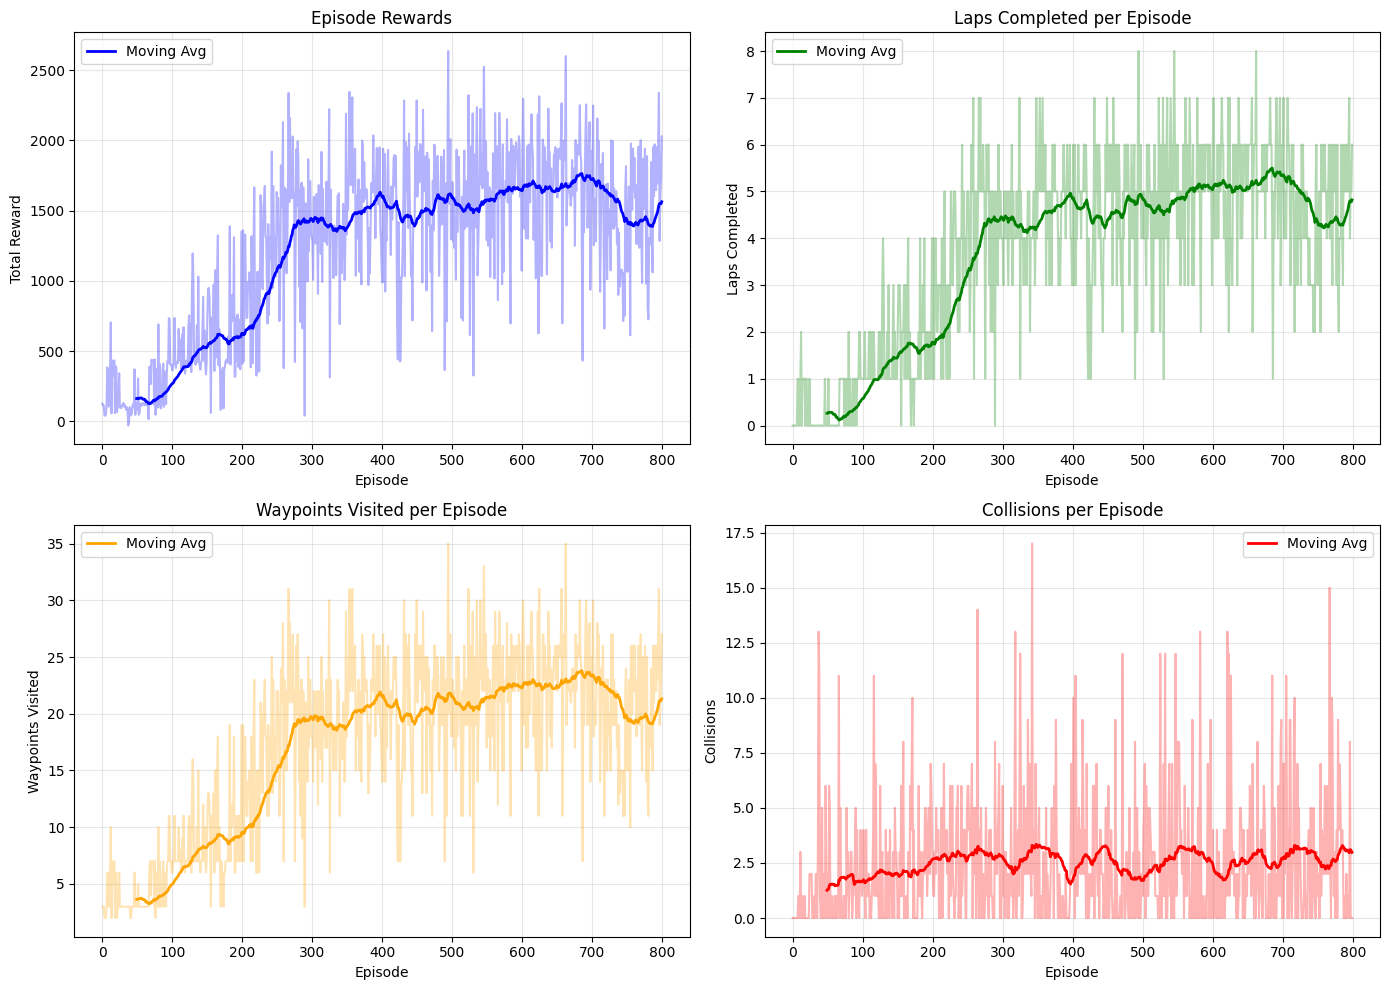

In [ ]:
def moving_average(data, window=50):
    return np.convolve(data, np.ones(window)/window, mode='valid')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Rewards
ax1 = axes[0, 0]
ax1.plot(episode_rewards, alpha=0.3, color='blue')
if len(episode_rewards) > 50:
    ax1.plot(range(49, len(episode_rewards)), moving_average(episode_rewards),
             color='blue', linewidth=2, label='Moving Avg')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.set_title('Episode Rewards')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Laps
ax2 = axes[0, 1]
ax2.plot(episode_laps, alpha=0.3, color='green')
if len(episode_laps) > 50:
    ax2.plot(range(49, len(episode_laps)), moving_average(episode_laps),
             color='green', linewidth=2, label='Moving Avg')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Laps Completed')
ax2.set_title('Laps Completed per Episode')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Waypoints
ax3 = axes[1, 0]
ax3.plot(episode_waypoints, alpha=0.3, color='orange')
if len(episode_waypoints) > 50:
    ax3.plot(range(49, len(episode_waypoints)), moving_average(episode_waypoints),
             color='orange', linewidth=2, label='Moving Avg')
ax3.set_xlabel('Episode')
ax3.set_ylabel('Waypoints Visited')
ax3.set_title('Waypoints Visited per Episode')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Collisions
ax4 = axes[1, 1]
ax4.plot(episode_collisions, alpha=0.3, color='red')
if len(episode_collisions) > 50:
    ax4.plot(range(49, len(episode_collisions)), moving_average(episode_collisions),
             color='red', linewidth=2, label='Moving Avg')
ax4.set_xlabel('Episode')
ax4.set_ylabel('Collisions')
ax4.set_title('Collisions per Episode')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=150)
plt.show()

## 7. Evaluation

In [ ]:
def evaluate_agent(agent, env, n_episodes=50):
    eval_rewards = []
    eval_laps = []
    eval_collisions = []
    eval_waypoints = []

    for _ in range(n_episodes):
        obs, global_state = env.reset()
        episode_reward = 0

        while True:
            actions, _ = agent.select_actions(obs, deterministic=True)
            obs, global_state, reward, done, info = env.step(actions)
            episode_reward += reward

            if done:
                break

        eval_rewards.append(episode_reward)
        eval_laps.append(info['laps_completed'])
        eval_collisions.append(info['total_collisions'])
        eval_waypoints.append(info['total_waypoints_visited'])

    return {
        'rewards': eval_rewards,
        'laps': eval_laps,
        'collisions': eval_collisions,
        'waypoints': eval_waypoints
    }

print("Evaluating trained agent (50 episodes)...\n")
eval_results = evaluate_agent(agent, env, n_episodes=50)

print("=" * 50)
print("EVALUATION RESULTS")
print("=" * 50)
print(f"Average Reward:     {np.mean(eval_results['rewards']):.2f} ± {np.std(eval_results['rewards']):.2f}")
print(f"Average Laps:       {np.mean(eval_results['laps']):.2f} ± {np.std(eval_results['laps']):.2f}")
print(f"Average Waypoints:  {np.mean(eval_results['waypoints']):.2f} ± {np.std(eval_results['waypoints']):.2f}")
print(f"Average Collisions: {np.mean(eval_results['collisions']):.2f} ± {np.std(eval_results['collisions']):.2f}")
print("=" * 50)

success_rate = sum(1 for l in eval_results['laps'] if l >= 1) / len(eval_results['laps']) * 100
print(f"\nSuccess Rate (≥1 lap): {success_rate:.1f}%")

Evaluating trained agent (50 episodes)...

EVALUATION RESULTS
Average Reward:     2878.00 ± 0.00
Average Laps:       9.00 ± 0.00
Average Waypoints:  37.00 ± 0.00
Average Collisions: 0.00 ± 0.00

Success Rate (≥1 lap): 100.0%


## 8. Trajectory Visualization

Visualizing trained agent...


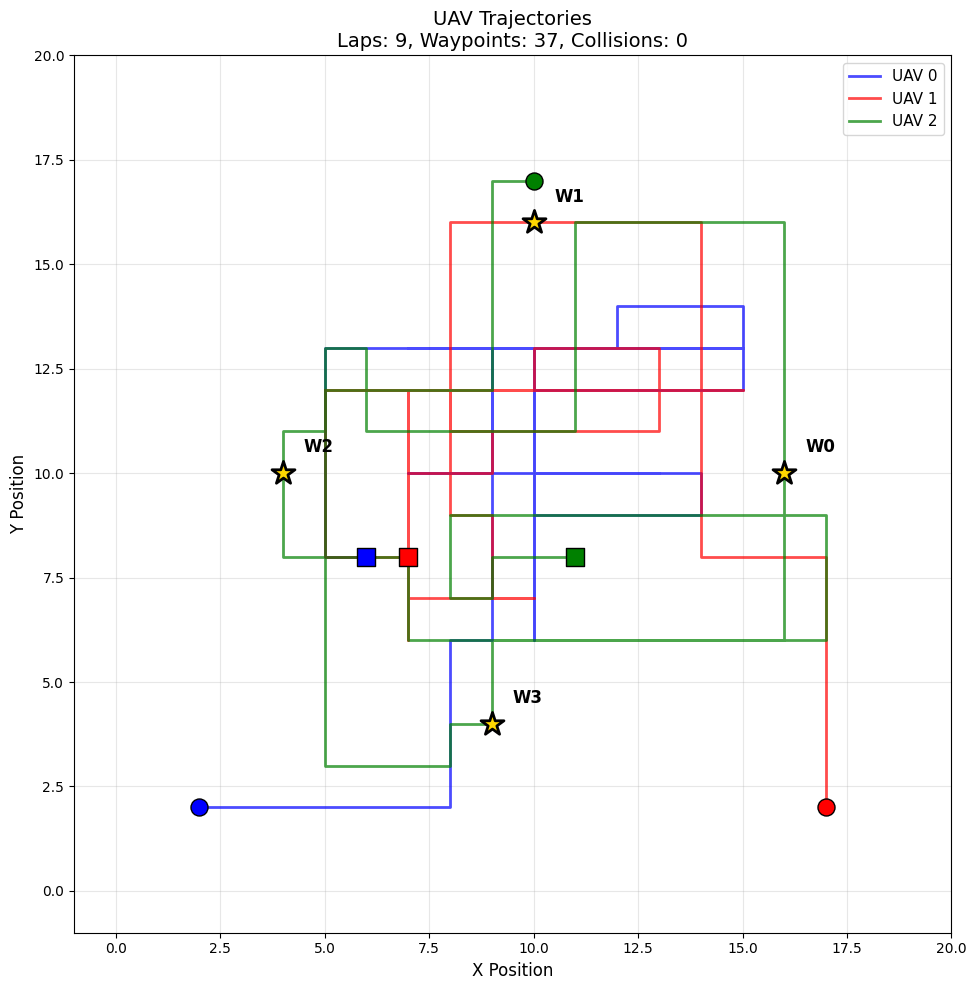


Episode: 9 laps, 37 waypoints, 0 collisions


In [ ]:
def visualize_episode(agent, env):
    obs, global_state = env.reset()

    trajectories = [[(pos[0], pos[1])] for pos in env.agent_positions]
    waypoints = [tuple(wp) for wp in env.waypoint_positions]

    while True:
        actions, _ = agent.select_actions(obs, deterministic=True)
        obs, global_state, reward, done, info = env.step(actions)

        for i in range(env.n_agents):
            trajectories[i].append((env.agent_positions[i][0], env.agent_positions[i][1]))

        if done:
            break

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = ['blue', 'red', 'green']

    # Waypoints
    for i, wp in enumerate(waypoints):
        ax.scatter(wp[0], wp[1], s=300, c='gold', marker='*',
                   edgecolors='black', linewidth=2, zorder=5)
        ax.annotate(f'W{i}', (wp[0]+0.5, wp[1]+0.5), fontsize=12, fontweight='bold')

    # Trajectories
    for i, traj in enumerate(trajectories):
        xs, ys = zip(*traj)
        ax.plot(xs, ys, color=colors[i], alpha=0.7, linewidth=2, label=f'UAV {i}')
        ax.scatter(xs[0], ys[0], s=150, c=colors[i], marker='o', edgecolors='black', zorder=6)
        ax.scatter(xs[-1], ys[-1], s=150, c=colors[i], marker='s', edgecolors='black', zorder=6)

    ax.set_xlim(-1, env.grid_size)
    ax.set_ylim(-1, env.grid_size)
    ax.set_xlabel('X Position', fontsize=12)
    ax.set_ylabel('Y Position', fontsize=12)
    ax.set_title(f'UAV Trajectories\nLaps: {info["laps_completed"]}, '
                 f'Waypoints: {info["total_waypoints_visited"]}, '
                 f'Collisions: {info["total_collisions"]}', fontsize=14)
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

    plt.tight_layout()
    plt.savefig('trajectory_plot.png', dpi=150)
    plt.show()

    return info

print("Visualizing trained agent...")
episode_info = visualize_episode(agent, env)
print(f"\nEpisode: {episode_info['laps_completed']} laps, "
      f"{episode_info['total_waypoints_visited']} waypoints, "
      f"{episode_info['total_collisions']} collisions")

## 9. Summary

### Algorithm: MAPPO
- **Centralized Training, Decentralized Execution (CTDE)**
- Critic sees global state → better coordination
- Actors only see local observations → scalable

### Key Design Choices:
1. **Shared Actor** (parameter sharing)
2. **Centralized Critic**
3. **Shared Team Reward** (fully cooperative)
4. **PPO Clipping** for stability
5. **Reward Shaping** to guide learning

### Metrics:
- Success Rate: % episodes with ≥1 lap
- Collision Rate
- Reward Curves
- Trajectory Plots

In [ ]:
print("\n" + "=" * 60)
print("FINAL SUMMARY")
print("=" * 60)
print(f"\nEnvironment: {GRID_SIZE}x{GRID_SIZE} grid, {N_AGENTS} UAVs, {N_WAYPOINTS} waypoints")
print(f"Training: {N_EPISODES} episodes")
print(f"\nFinal Performance (last 100 episodes):")
print(f"  Avg Reward: {np.mean(episode_rewards[-100:]):.2f}")
print(f"  Avg Laps: {np.mean(episode_laps[-100:]):.2f}")
print(f"  Avg Waypoints: {np.mean(episode_waypoints[-100:]):.2f}")
print(f"  Avg Collisions: {np.mean(episode_collisions[-100:]):.2f}")
print("=" * 60)


FINAL SUMMARY

Environment: 20x20 grid, 3 UAVs, 4 waypoints
Training: 800 episodes

Final Performance (last 100 episodes):
  Avg Reward: 1498.78
  Avg Laps: 4.60
  Avg Waypoints: 20.54
  Avg Collisions: 2.87
